In [ ]:
!pip install gdal

calculating indices


In [ ]:
from osgeo import gdal
import matplotlib.pyplot as plt

Stack_File=gdal.Open(r"/content/drive/MyDrive/loktak_ML/lokat2022_stack.tif")
#print(Stack_File)
nobands=Stack_File.RasterCount
print(nobands)
cols=Stack_File.RasterXSize
rows=Stack_File.RasterYSize

red=Stack_File.GetRasterBand(4)
nir=Stack_File.GetRasterBand(5)

nirb=nir.ReadAsArray(0,0,cols,rows).astype(float)
redb=red.ReadAsArray(0,0,cols,rows).astype(float)
red_reflectance = redb
nir_reflectance = nirb
ndvi = (nir_reflectance - red_reflectance) / (nir_reflectance + red_reflectance)

plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.show()


In [ ]:
L = 0.5
savi = (nirb - redb) / (nirb + redb + L) * (1 + L)


In [ ]:
swir = Stack_File.GetRasterBand(6)
swirb = swir.ReadAsArray(0,0,cols,rows).astype(float)

ndwi = (nirb - swirb) / (nirb + swirb)
#print(ndwi)
plt.imshow(ndwi, cmap='RdYlGn')
plt.colorbar()
plt.show()


In [ ]:
ndbi = (swirb - nirb) / (swirb + nirb)


In [ ]:
# modified water index
green = Stack_File.GetRasterBand(3)
grnb = green.ReadAsArray(0,0,cols,rows).astype(float)

mndwi = (grnb - swirb) / (grnb + swirb)


In [ ]:
#enhanced vegetation index
blue = Stack_File.GetRasterBand(2)
blueb = blue.ReadAsArray(0,0,cols,rows).astype(float)

evi = 2.5 * (nirb - redb) / (nirb + 6 * redb - 7.5 * blueb + 1)


<ipython-input-7-2d27029a00d1>:5: RuntimeWarning: divide by zero encountered in divide
  evi = 2.5 * (nirb - redb) / (nirb + 6 * redb - 7.5 * blueb + 1)


In [ ]:
# chlorophyll index
ci = redb / nirb


In [ ]:
#advanced vegetsation index
import numpy as np

avi = np.sqrt(nirb * (1 - redb) * (nirb - redb))


<ipython-input-9-5e8eb230e179>:4: RuntimeWarning: invalid value encountered in sqrt
  avi = np.sqrt(nirb * (1 - redb) * (nirb - redb))


In [ ]:
# land surface water index
lswi = (nirb - swirb) / (nirb + swirb)
plt.imshow(lswi, cmap='RdYlGn')
plt.colorbar()
plt.show()

In [ ]:
# pond index
ndpi = (grnb - blueb) / (grnb + blueb)
plt.imshow(ndpi, cmap='RdYlGn')
plt.colorbar()
plt.show()

In [ ]:
# wetness index
mir = Stack_File.GetRasterBand(7)
mirb = mir.ReadAsArray(0,0,cols,rows).astype(float)

ndweti = (nirb - mirb) / (nirb + mirb)

plt.imshow(ndweti, cmap='RdYlGn')
plt.colorbar()
plt.show()

In [ ]:
# wetland water index
wwi = (nirb - mirb) / (nirb + mirb) - (grnb - swirb) / (grnb + swirb)
plt.imshow(wwi, cmap='RdYlGn')
plt.colorbar()
plt.show()

converting indices to TIFF file


In [ ]:
!pip install rasterio

In [ ]:
import rasterio as rs
src = rs.open("/content/drive/MyDrive/loktak_ML/loktak_stacked.tif")

In [ ]:
profile = src.profile
print(profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 2195, 'height': 2137, 'count': 7, 'crs': CRS.from_epsg(32646), 'transform': Affine(30.0, 0.0, 558375.0,
       0.0, -30.0, 2746785.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'pixel'}


In [ ]:
profile = src.profile
profile.update(dtype=rs.float32,count=1,compress='lzw')  # Set the number of bands to 1 for the output image
with rs.open('/content/drive/MyDrive/loktak_ML/indices2022/ci.tif', 'w', **profile) as dst:
    dst.write(ci, 1)

extraction of values


In [ ]:
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
import numpy as np
import csv
import os
data = []
# Load the point shapefile
points = gpd.read_file('/content/drive/MyDrive/loktak_ML/points_shapefile/pointss.shp')

image_directory = '/content/drive/MyDrive/loktak_ML/indices2022'
#print(image_directory)
csv_file = 'data2022.csv'
# Load the raster
for filename in os.listdir(image_directory):
    if filename.endswith('.tif'):
      image_path = os.path.join(image_directory, filename)
      print(filename)
      with rasterio.open(image_path) as rs_src:
        transform = rs_src.transform
        #print(rs_src.meta)
    # Get the raster values at the points
        for idx, point in points.iterrows():
            #print(point['lat'],point['lng'])
            lat = point['lat']
            lng = point['lng']
            typ_cls = point['class']
            row, col = rs_src.index(point.geometry.x, point.geometry.y)
            value = rs_src.read(1)[row, col]
            #print(f"Value at point {idx}: {value}")
            data.append((lat,lng,typ_cls,value))
            with open(csv_file, 'w', newline='') as file:
                  writer = csv.writer(file)
                  writer.writerow(['lat','lng' ,'class','value'])
                  #for row in data: # Write header row
                  writer.writerows(data)  # Write data rows'''

print(f"CSV file '{csv_file}' created successfully.")

wwi.tif
savi.tif
ndwetness_i.tif
ndwi.tif
ndvi.tif
ndpi.tif
ndbi.tif
mndwi.tif
lswi.tif
evi.tif
ci.tif
CSV file 'data2022.csv' created successfully.


reading csv file

In [2]:
import pandas as pd
dataa=pd.read_csv('/content/drive/MyDrive/loktak_ML/dataa.csv')
print(dataa.head())

           lat          lng     class      lswi        ci       evi     mndwi  \
0  593371.4487  2743337.075  built-up -0.039067  0.924150 -0.186003 -0.068559   
1  594521.5191  2742327.360  built-up -0.019855  0.939384 -0.142449 -0.037041   
2  595513.1477  2743586.545  built-up  0.092610  0.741252 -0.728999 -0.027865   
3  596216.6624  2745156.891  built-up  0.101221  1.190400  0.224019  0.223433   
4  593716.4419  2745139.678  built-up -0.057975  0.913580 -0.355941 -0.105537   

       ndbi      ndwi      savi      ndvi      ndpi   wetness       wwi  
0  0.039067 -0.039067  0.059128  0.039420 -0.033846 -0.010359  0.058200  
1  0.019855 -0.019855  0.046881  0.031255 -0.030364  0.002624  0.039665  
2 -0.092610  0.092610  0.222892  0.148599 -0.036322  0.160566  0.188431  
3 -0.101221  0.101221 -0.130383 -0.086925 -0.031326  0.119203 -0.104230  
4  0.057975 -0.057975  0.067740  0.045161 -0.019679 -0.040823  0.064715  


In [ ]:
dataa.info()
dataa.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   lat      303 non-null    float64
 1   lng      303 non-null    float64
 2   class    303 non-null    object 
 3   lswi     303 non-null    float64
 4   ci       303 non-null    float64
 5   evi      303 non-null    float64
 6   mndwi    303 non-null    float64
 7   ndbi     303 non-null    float64
 8   ndwi     303 non-null    float64
 9   savi     303 non-null    float64
 10  ndvi     303 non-null    float64
 11  ndpi     303 non-null    float64
 12  wetness  303 non-null    float64
 13  wwi      303 non-null    float64
dtypes: float64(13), object(1)
memory usage: 33.3+ KB


Index(['lat', 'lng', 'class', 'lswi', 'ci', 'evi', 'mndwi', 'ndbi', 'ndwi',
       'savi', 'ndvi', 'ndpi', 'wetness', 'wwi'],
      dtype='object')

<ipython-input-32-0bfbad997697>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(dataa.corr()))
<ipython-input-32-0bfbad997697>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataplot = snb.heatmap(dataa.corr(), cmap="YlGnBu", annot=True, mask=mask)


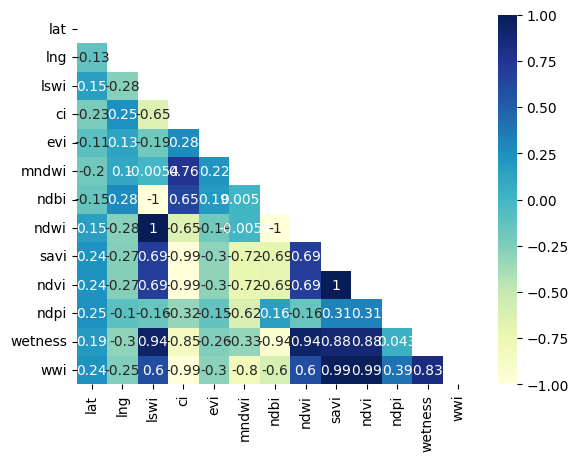

In [ ]:
import seaborn as snb
import numpy as np

# creating mask
mask = np.triu(np.ones_like(dataa.corr()))

# plotting a triangle correlation heatmap
dataplot = snb.heatmap(dataa.corr(), cmap="YlGnBu", annot=True, mask=mask)

Assigning training testing dataset

In [ ]:
x=dataa[['lat', 'lng','lswi', 'ci', 'evi', 'mndwi', 'ndbi', 'ndwi','savi', 'ndvi', 'ndpi', 'wetness', 'wwi']]
y=dataa['class']
print(x.shape)
print(y.shape)

Spilliting dataset


In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

Training and evaluation of models


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn                        import metrics, svm
from sklearn.linear_model           import LogisticRegression
from sklearn.tree                   import DecisionTreeClassifier
from sklearn.neighbors              import KNeighborsClassifier
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis
from sklearn.naive_bayes            import GaussianNB
from sklearn.svm                    import SVC
from sklearn.preprocessing          import LabelBinarizer
from sklearn.metrics                import RocCurveDisplay
from sklearn.metrics                import ConfusionMatrixDisplay
from sklearn.metrics                import classification_report as cr


clf = LogisticRegression()
name = "LogisticRegression"
clf.fit(x_train, y_train)
print("LogisticRegression")
y_pred = clf.predict(x_test)
print(y_pred)
print(cr(y_pred,y_test))

y_scores = clf.predict_proba(x_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
label_binarizer.transform(["wetland"])

class_of_interest = "wetland"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_scores[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nWetland vs (built-up & Vegetation) (LogisticRegression)")
plt.legend(loc='lower right')
plt.show()

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization (LogisticRegression)", None),
    ("Normalized confusion matrix (LogisticRegression)", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        x_test,
        y_test,
        display_labels=['built-up','vegetation','wetland'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)


plt.show()

print("######\n######\n#######\n#####")

clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
print("DecisionTreeClassifier")

y_pred = clf.predict(x_test)
print(y_pred)

print(cr(y_pred,y_test))

y_scores = clf.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
label_binarizer.transform(["wetland"])

class_of_interest = "wetland"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_scores[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nWetland vs (built-up & Vegetation) (DecisionTreeClassifier)")
plt.legend(loc='lower right')
plt.show()

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization (DecisionTreeClassifier)", None),
    ("Normalized confusion matrix (DecisionTreeClassifier)", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        x_test,
        y_test,
        display_labels=['built-up','vegetation','wetland'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)


plt.show()

print("######\n######\n#######\n#####")


clf = KNeighborsClassifier()
clf.fit(x_train, y_train)
print("KNeighborsClassifier")

y_pred = clf.predict(x_test)
print(y_pred)

print(cr(y_pred,y_test))

y_scores = clf.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
label_binarizer.transform(["wetland"])

class_of_interest = "wetland"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_scores[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nWetland vs (built-up & Vegetation) (KNeighborsClassifier)")
plt.legend(loc='lower right')
plt.show()

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization (KNeighborsClassifier)", None),
    ("Normalized confusion matrix (KNeighborsClassifier)", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        x_test,
        y_test,
        display_labels=['built-up','vegetation','wetland'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)


plt.show()
print("######\n######\n#######\n#####")

clf = LinearDiscriminantAnalysis()
clf.fit(x_train, y_train)
print("LinearDiscriminantAnalysis")

y_pred = clf.predict(x_test)
print(y_pred)

print(cr(y_pred,y_test))

y_scores = clf.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
label_binarizer.transform(["wetland"])

class_of_interest = "wetland"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_scores[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nWetland vs (built-up & Vegetation) (LinearDiscriminantAnalysis)")
plt.legend(loc='lower right')
plt.show()

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization (LinearDiscriminantAnalysis)", None),
    ("Normalized confusion matrix (LinearDiscriminantAnalysis)", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        x_test,
        y_test,
        display_labels=['built-up','vegetation','wetland'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)


plt.show()

print("######\n######\n#######\n#####")

clf = GaussianNB()
clf.fit(x_train, y_train)
print("GaussianNB")

y_pred = clf.predict(x_test)
print(y_pred)

print(cr(y_pred,y_test))

y_scores = clf.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
label_binarizer.transform(["wetland"])

class_of_interest = "wetland"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_scores[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nWetland vs (built-up & Vegetation) (GaussianNB)")
plt.legend(loc='lower right')
plt.show()

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization (GaussianNB)", None),
    ("Normalized confusion matrix (GaussianNB)", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        x_test,
        y_test,
        display_labels=['built-up','vegetation','wetland'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)


plt.show()

print("######\n######\n#######\n#####")

clf = SVC(probability=True)
clf.fit(x_train, y_train)
print("SVC")

y_pred = clf.predict(x_test)
print(y_pred)

print(cr(y_pred,y_test))

y_scores = clf.predict_proba(x_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
label_binarizer.transform(["wetland"])

class_of_interest = "wetland"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_scores[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nWetland vs (built-up & Vegetation) (SVC)")
plt.legend(loc='lower right')
plt.show()

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization (SVC)", None),
    ("Normalized confusion matrix (SVC)", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        x_test,
        y_test,
        display_labels=['built-up','vegetation','wetland'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.show()


reading 2022 csv dataset

In [ ]:
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/loktak_ML/data2022new.csv')
print(data.info())

In [7]:
x2022=data[['lat', 'lng','lswi', 'ci', 'evi', 'mndwi', 'ndbi', 'ndwi','savi', 'ndvi', 'ndpi', 'wetness', 'wwi']]
y2022=data['class']
print(x2022.shape)
print(y2022.shape)


(303, 13)
(303,)


In [8]:
from sklearn.model_selection import train_test_split
x_train22, x_test22, y_train22, y_test22 = train_test_split(x2022, y2022, test_size=0.90, random_state=42)

In [ ]:
x_test22

prediction of 2022 dataset


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import csv
csv_file = 'results1.csv'
data = []
print("KNeighborsClassifier")
clf = KNeighborsClassifier()
model=clf.fit(x_train, y_train)
y_pred=model.predict(x_test22)
locations = ['lat','lng']
print(type(x_test))
# Iterate through predictions and corresponding instances in X_test
for i in range(len(y_pred)):
    prediction = y_pred[i]
    print(prediction)
    instance = x_test22.iloc[i]
    attr = instance[locations]
    #print(f"Prediction: {prediction}, \n  location Attributes: {attr}")
    lat = attr[0]
    lng = attr[1]
    data.append((lat,lng,prediction))
    with open(csv_file, 'w', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow(['lat','lng' ,'prediction'])
                    #for row in data: # Write header row
                    writer.writerows(data)  # Write data rows'''
print(f"CSV file '{csv_file}' created successfully.")